In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [16]:
class Dataset():
    def __init__(self, X, Y):
        self.X_data = X
        self.y_data = Y
  
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)

In [106]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

wine = load_wine()

X_train, X_test, y_train, y_test = train_test_split(wine.data, 
                                                    wine.target,
                                                    test_size=0.2,
                                                    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

batch_size = 8
train_dataloader = DataLoader(Dataset(X_train, y_train), 
                              batch_size=batch_size, 
                              shuffle=True, 
                              num_workers=batch_size)

In [107]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(13, n_hidden_neurons)
        self.act1 = torch.nn.Sigmoid()
        self.bn1 = torch.nn.BatchNorm1d(n_hidden_neurons)
        
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.act2 = torch.nn.Sigmoid()
        self.bn2 = torch.nn.BatchNorm1d(n_hidden_neurons)
        
        self.dp = torch.nn.Dropout(p=0.1)
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
        
        self.sm = torch.nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.bn1(x)
        
        x = self.fc2(x)
        x = self.act2(x)
        x = self.bn2(x)
        
        x = self.dp(x)
        x = self.fc3(x)
        return x
    
    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
wine_net = WineNet(128).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(wine_net.parameters(), lr=1e-3, weight_decay=1e-5)

In [108]:
accuracy = lambda preds, y: (preds.argmax(dim=1) == y).float().mean().data
mean = lambda l: sum(l) / len(l)

acc_train_hist = []
lss_train_hist = []
acc_test_hist = []
lss_test_hist = []

for epoch in range(150):
    wine_net.train()
    
    acc_train_batch = []
    lss_train_batch = []
    
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        preds = wine_net(X_batch)
        loss_val = loss(preds, y_batch)
        loss_val.backward()
        optimizer.step()
        
        lss_train_batch.append(loss_val.data)
        acc_train_batch.append(accuracy(preds, y_batch))
         
    wine_net.eval()
    test_preds = wine_net.forward(X_test)
    
    acc_train_hist.append(mean(acc_train_batch))   
    lss_train_hist.append(mean(lss_train_batch))
    acc_test_hist.append(accuracy(test_preds, y_test))
    lss_test_hist.append(loss(test_preds, y_test.squeeze()).data)

In [113]:
from sklearn.metrics import classification_report

wine_net.eval()
preds = wine_net.forward(X_test).argmax(dim=1).detach().numpy()
test = y_test.detach().numpy()
report = classification_report(test, preds)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.87      1.00      0.93        13
           2       1.00      0.93      0.97        15

    accuracy                           0.94        36
   macro avg       0.96      0.94      0.94        36
weighted avg       0.95      0.94      0.95        36



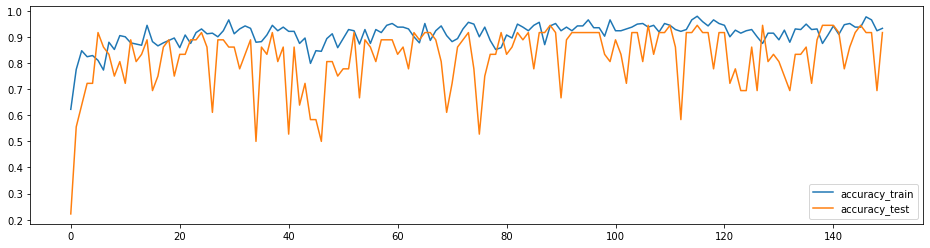

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 4))
plt.plot(acc_train_hist, label='accuracy_train')
plt.plot(acc_test_hist, label='accuracy_test')
plt.legend()

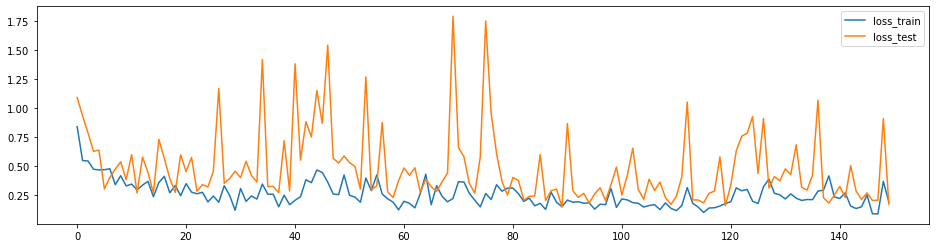

In [115]:
plt.figure(figsize=(16, 4))

plt.plot(lss_train_hist, label='loss_train')
plt.plot(lss_test_hist, label='loss_test')
plt.legend()

In [86]:
torch.save(wine_net, 'wine.pth')